# load data
"All patients were not treated with chemotherapy or radiotherapy before tumor resection"

In [ ]:
exp1 <- fread('/project/sex_cancer/data/ESCC_Zhang2021/GSE160269_CD45neg_UMIs.txt') %>% column_to_rownames('V1')
exp2 <- fread('/project/sex_cancer/data/ESCC_Zhang2021/GSE160269_CD45pos_UMIs.txt') %>% column_to_rownames('V1')

all_genes <- unique(c(rownames(exp1), rownames(exp2)))
# create merged df
exp_merge <- data.frame(matrix(0, nrow = length(all_genes), ncol = ncol(exp1) + ncol(exp2)))
rownames(exp_merge) <- all_genes
colnames(exp_merge) <- c(colnames(exp1), colnames(exp2))
# load data
exp_merge[rownames(exp1), colnames(exp1)] <- exp1
exp_merge[rownames(exp2), colnames(exp2)] <- exp2

In [ ]:
metaList <- list.files('/project/sex_cancer/data/ESCC_Zhang2021', pattern = 'GSE160269_*cells', full.names = TRUE)
meta <- lapply(metaList, function(x){fread(x)}) %>% 
        do.call(rbind, .) %>%
        transform(DonorID = gsub('T|N','', sample), barcode = rownames(.))

info <- read_xlsx('./ESCC_Zhang2021/ESCC_Zhang2021_PatienInfo.xlsx',skip = 1)
names(info)[1]='DonorID'
meta  <- merge(meta, info, by = 'DonorID',all = TRUE) %>% column_to_rownames('barcode') %>% mutate_if(~!is.numeric(.), ext_list) %>% .[colnames(exp_merge),]

In [2]:
obj.ESCA <- CreateSeuratObject(counts = exp_merge, meta.data = meta, min.cells = 0,min.features = 0)
obj.ESCA

# modify meta.data

In [1]:
## 60patient ~ 64 samples (4 normal_adjacent）
obj.ESCA@meta.data <- obj.ESCA@meta.data %>% 
                      dplyr::rename(c('SampleID' = 'sample')) %>%
                      transform(Cohort = 'ESCA_Zhang2021') %>%
                      mutate(Sex = case_when(Sex == 'Female' ~ 'F', Sex == 'Male' ~ 'M', TRUE ~ 'Others')) %>%
                      mutate(SampleType = case_when(SampleID %in% c('P126N', 'P127N', 'P128N', 'P130N') ~ 'normal_adjacent', TRUE ~ 'tumor'))
obj.ESCA@meta.data %>% head(n = 2)

In [17]:
obj.ESCA@meta.data[,c('SampleID', 'SampleType', 'Sex')] %>% .[!duplicated(.$SampleID),] %$% table(.$SampleType, .$Sex)
obj.ESCA@meta.data %>% subset(SampleType == 'tumor') %>% nrow()

                 
                   F  M
  normal_adjacent  0  4
  tumor           16 44

[1] 192078

# cell type annotation

In [67]:
unique(obj.ESCA$oCT)

[1] "Epithelial"  "Bcell"       "Endothelial" "Fibroblast"  "FRC"        
[6] "Tcell"       "Myeloid"     "Pericytes"

In [71]:
obj.ESCA@meta.data <- obj.ESCA@meta.data %>% 
                      mutate(dCT = case_when(oCT %in% c('Epithelial') ~ 'Tumor',
                                             oCT %in% c('Bcell') ~ 'B/Plasma',
                                             oCT %in% c('Endothelial') ~ 'Endo',
                                             oCT %in% c('Fibroblast') ~ 'Fibro',
                                             oCT %in% c('Tcell') ~ 'NK/T',
                                             oCT %in% c('Pericytes') ~ 'Pericyte',
                                             oCT %in% c('FRC') ~ 'FRC', ## Fibroblastic Reticular Cells成纤维网状细胞，可以视为一类特殊化的Fibroblast，形成三维网状支架，为其它细胞的迁移和互作提供物理支持
                                             TRUE ~ oCT))

## assign NK/T

In [6]:
obj.ESCA.nkt <- obj.ESCA %>% subset(dCT == 'NK/T')
obj.ESCA.nkt

obj.ESCA.nkt <- obj.ESCA.nkt %>%
                 NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
                 FindVariableFeatures(selection.method = "vst", nfeatures = 1000, verbose = F) %>%
                 ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>%
                 RunPCA(verbose = F) %>% 
                 RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)
## cluster
nPC <- min(PC_selection_harmony(obj.ESCA.nkt)$PCselect)
obj.ESCA.nkt <- obj.ESCA.nkt %>% 
                 RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot") %>%
                 FindNeighbors(reduction = "harmony", dims = 1:nPC) %>%
                 FindClusters(resolution=0.1) %>% FindClusters(resolution=0.2) %>% FindClusters(resolution=0.3) %>% FindClusters(resolution=0.4)
colnames(obj.ESCA.nkt@meta.data) <- gsub("RNA_snn_res.0.","r0", colnames(obj.ESCA.nkt@meta.data))

An object of class Seurat 
17986 features across 69278 samples within 1 assay 
Active assay: RNA (17986 features, 0 variable features)

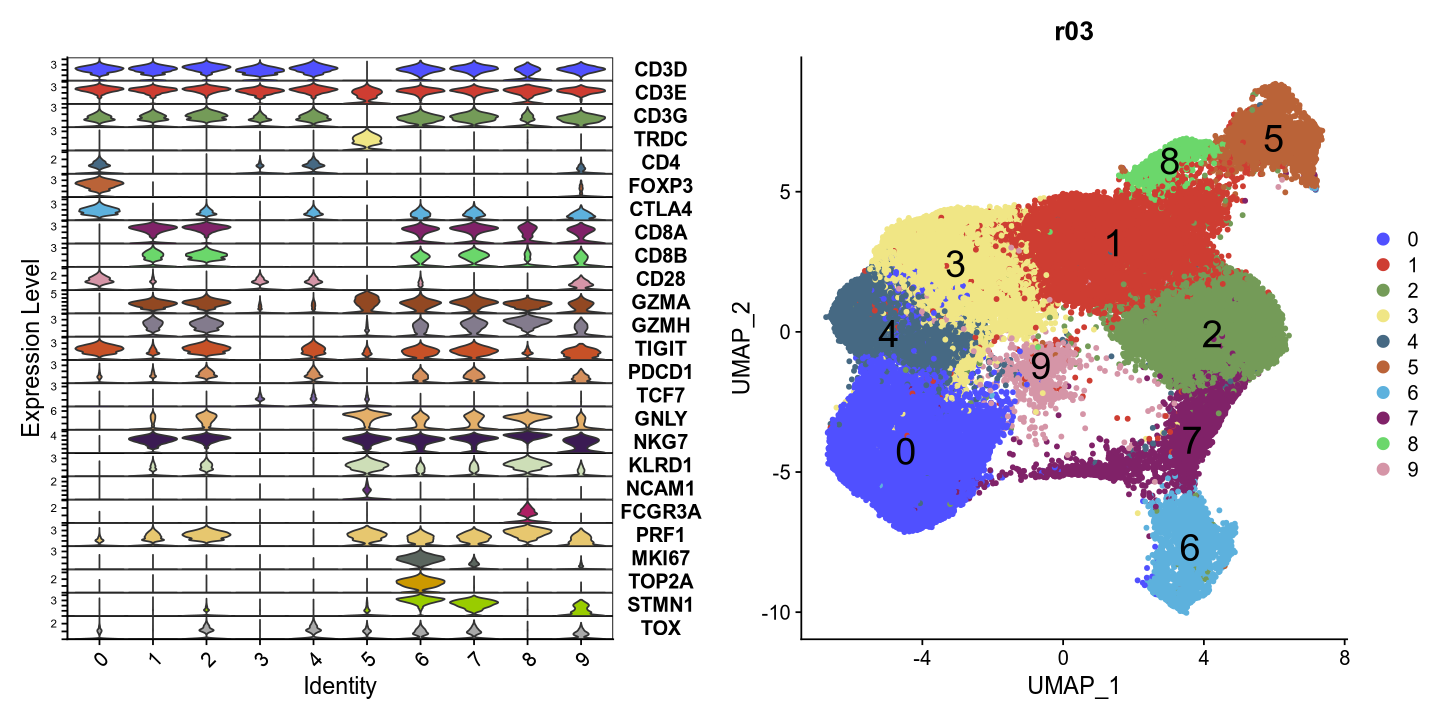

In [124]:
## view marker
marker_list <- c('CD3D', 'CD3E', 'CD3G', 'TRDC',
                 'CD4','FOXP3', 'CTLA4', ## Treg: 'FOXP3', 'CTLA4'
                 'CD8A', 'CD8B', 'CD28', 'GZMA', 'GZMH',
                 'TIGIT', 'PDCD1', 'TCF7',
                 'GNLY', 'NKG7', 'KLRD1', 'NCAM1', 'FCGR3A', 'PRF1', ## NK NCAM1-CD56 FCGR3A-CD16
                 'MKI67', 'TOP2A', 'STMN1', 'TOX')

options(repr.plot.height = 6, repr.plot.width = 12)
VlnPlot(obj.ESCA.nkt, group.by = 'r03', features = marker_list, pt.size = 0, cols = pal_igv("default")(51), 
        slot = 'data',assay = 'RNA', raster=FALSE, stack = TRUE, flip = TRUE)+
theme(legend.position = 'none')|
DimPlot_scCustom(obj.ESCA.nkt, pt.size = 1, group.by = "r03", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))

In [ ]:
Idents(obj.ESCA.nkt) <- factor(obj.ESCA.nkt$r03, levels = 9:0)
cluster_deg <- FindAllMarkers(obj.ESCA.nkt, assay = "RNA", slot = "data",
                              logfc.threshold = 0.25, min.pct = 0.1, test.use = "wilcox")
rownames(cluster_deg) <- NULL

In [120]:
## assign mCT/dCT
obj.ESCA.nkt@meta.data <- obj.ESCA.nkt@meta.data %>%
                          mutate(dCT = case_when(r03 %in% c('0') ~ 'Treg',
                                                 r03 %in% c('5') ~ 'NK',
                                                 r03 %in% c('8') ~ 'NKT',
                                                 r03 %in% c('1', '2', '7') ~ 'CD8T',
                                                 r03 %in% c('6') ~ 'CD8T_proliferation',
                                                 r03 %in% c('3') ~ 'CD4Tnaive',
                                                 r03 %in% c('4') ~ 'CD4Tfh',
                                                 r03 %in% c('9') ~ 'CD4T',
                                                 TRUE ~ 'Others'
                                                 )) %>%
                          mutate(mCT = case_when(r03 %in% c('0') ~ 'Treg',
                                                 r03 %in% c('5') ~ 'NK',
                                                 r03 %in% c('8') ~ 'NKT',
                                                 r03 %in% c('1', '2', '6', '7') ~ 'CD8T',
                                                 r03 %in% c('3', '4', '9') ~ 'CD4T',
                                                 TRUE ~ 'Others'
                                                 )) 
obj.ESCA.nkt@meta.data <- obj.ESCA.nkt@meta.data %>% dplyr::select(-c('r01', 'r02', 'r03', 'r04', 'seurat_clusters'))

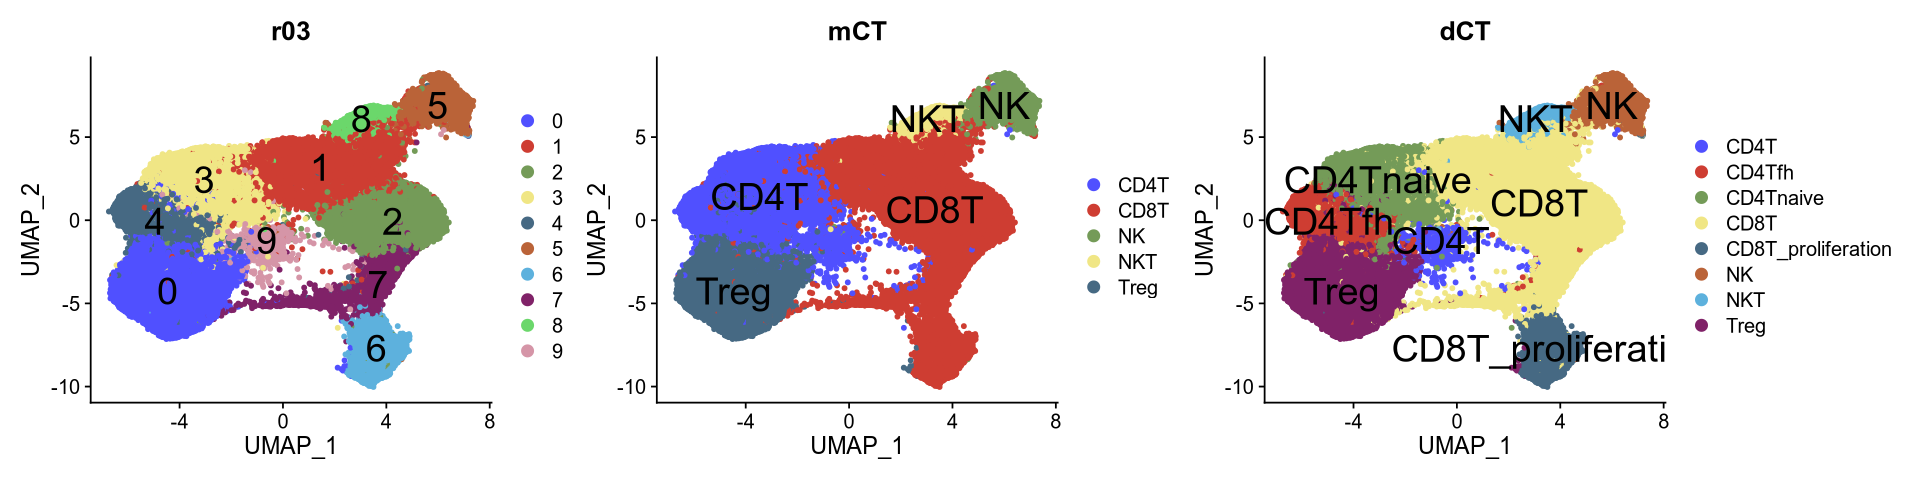

In [121]:
options(repr.plot.height = 4, repr.plot.width = 16)
DimPlot_scCustom(obj.ESCA.nkt, pt.size = 1, group.by = "r03", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.nkt, pt.size = 1, group.by = "mCT", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.nkt, pt.size = 1, group.by = "dCT", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))

## assign B/Plasma

In [93]:
obj.ESCA.bp <- obj.ESCA %>% subset(dCT == 'B/Plasma')
obj.ESCA.bp

obj.ESCA.bp <- obj.ESCA.bp %>%
                 NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
                 FindVariableFeatures(selection.method = "vst", nfeatures = 2000, verbose = F) %>%
                 ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>%
                 RunPCA(verbose = F) %>% 
                 RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)
## cluster
nPC <- min(PC_selection_harmony(obj.ESCA.bp)$PCselect)
obj.ESCA.bp <- obj.ESCA.bp %>% 
                 RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot") %>%
                 FindNeighbors(reduction = "harmony", dims = 1:nPC) %>%
                 FindClusters(resolution=0.1) %>% FindClusters(resolution=0.2) %>% FindClusters(resolution=0.3)
colnames(obj.ESCA.bp@meta.data) <- gsub("RNA_snn_res.0.","r0", colnames(obj.ESCA.bp@meta.data))

An object of class Seurat 
17986 features across 22477 samples within 1 assay 
Active assay: RNA (17986 features, 0 variable features)

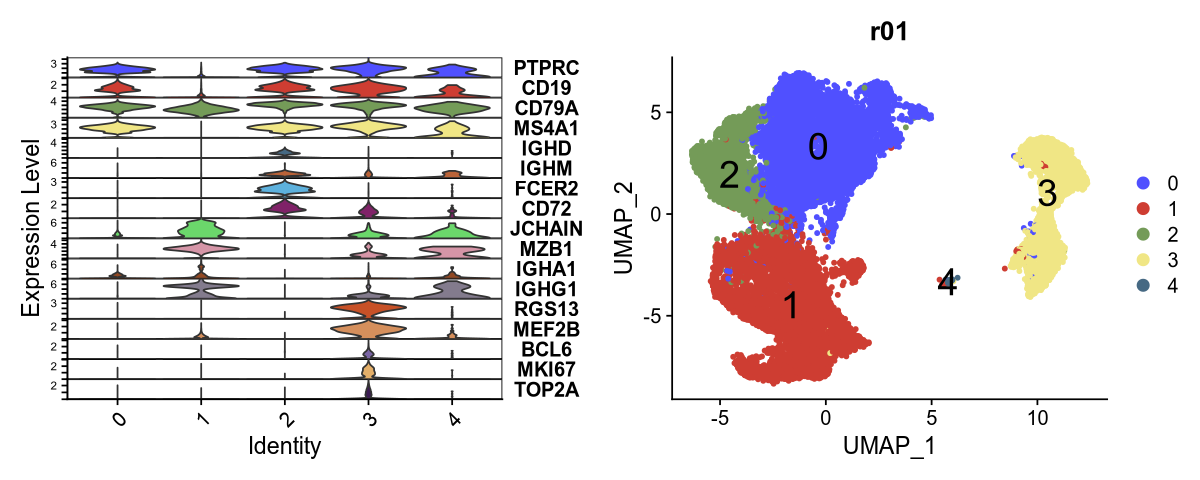

In [132]:
## marker expression
marker_list <- c('PTPRC', 'CD19', 'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'FCER2', 'CD72',  
                 'JCHAIN', 'MZB1',  'IGHA1', 'IGHG1', 
                 'RGS13', 'MEF2B', 'BCL6', 'MKI67', 'TOP2A')

options(repr.plot.height = 4, repr.plot.width = 10)
VlnPlot(obj.ESCA.bp, group.by = 'r01', features = marker_list, pt.size = 0, cols = pal_igv("default")(51), 
        slot = 'data',assay = 'RNA', raster=FALSE, stack = TRUE, flip = TRUE)+
theme(legend.position = 'none')|
DimPlot_scCustom(obj.ESCA.bp, pt.size = 1, reduction = 'umap', group.by = "r01", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))

In [103]:
Idents(obj.ESCA.bp) <- factor(obj.ESCA.bp$r01, levels = 4:0)
cluster_deg <- FindAllMarkers(obj.ESCA.bp, assay = "RNA", slot = "data",
                              logfc.threshold = 0.25, min.pct = 0.1, test.use = "wilcox")
rownames(cluster_deg) <- NULL

Calculating cluster 4

Calculating cluster 3

Calculating cluster 2

Calculating cluster 1

Calculating cluster 0



In [138]:
## assign mCT/dCT
obj.ESCA.bp@meta.data <- obj.ESCA.bp@meta.data %>%
                          mutate(dCT = case_when(r01 %in% c('0', '2') ~ 'B',
                                                 r01 %in% c('1') ~ 'Plasma',
                                                 r01 %in% c('3') ~ 'B_GerminalCenter',
                                                 r01 %in% c('4') ~ 'Others',
                                                 TRUE ~ 'Others'
                                                 )) %>%
                          mutate(mCT = case_when(r01 %in% c('0', '2', '3') ~ 'B',
                                                 r01 %in% c('1') ~ 'Plasma',
                                                 r01 %in% c('4') ~ 'Others',
                                                 TRUE ~ 'Others'
                                                 )) 
obj.ESCA.bp@meta.data <- obj.ESCA.bp@meta.data %>% dplyr::select(-c('r02', 'r03', 'seurat_clusters'))

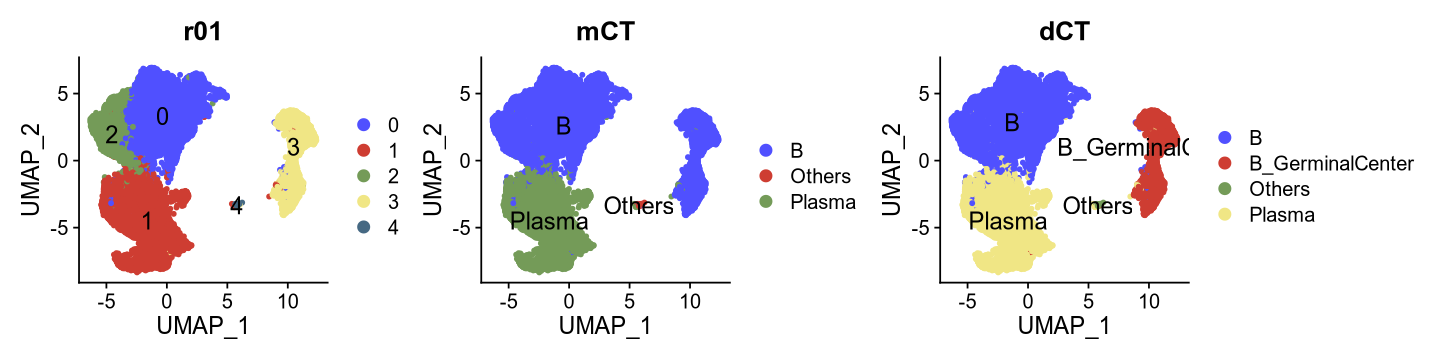

In [139]:
options(repr.plot.height = 3, repr.plot.width = 12)
DimPlot_scCustom(obj.ESCA.bp, pt.size = 1, group.by = "r01", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.bp, pt.size = 1, group.by = "mCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.bp, pt.size = 1, group.by = "dCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))

## assign Myeloid

In [202]:
obj.ESCA.mye <- obj.ESCA %>% subset(dCT == 'Myeloid')
obj.ESCA.mye

obj.ESCA.mye <- obj.ESCA.mye %>%
                 NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
                 FindVariableFeatures(selection.method = "vst", nfeatures = 3000, verbose = F) %>%
                 ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>%
                 RunPCA(verbose = F) %>% 
                 RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)
## cluster
nPC <- min(PC_selection_harmony(obj.ESCA.mye)$PCselect)
obj.ESCA.mye <- obj.ESCA.mye %>% 
                 RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot") %>%
                 FindNeighbors(reduction = "harmony", dims = 1:nPC) %>%
                 FindClusters(resolution=0.1) %>% FindClusters(resolution=0.2) %>% FindClusters(resolution=0.3)
colnames(obj.ESCA.mye@meta.data) <- gsub("RNA_snn_res.0.","r0", colnames(obj.ESCA.mye@meta.data))

An object of class Seurat 
17986 features across 19273 samples within 1 assay 
Active assay: RNA (17986 features, 0 variable features)

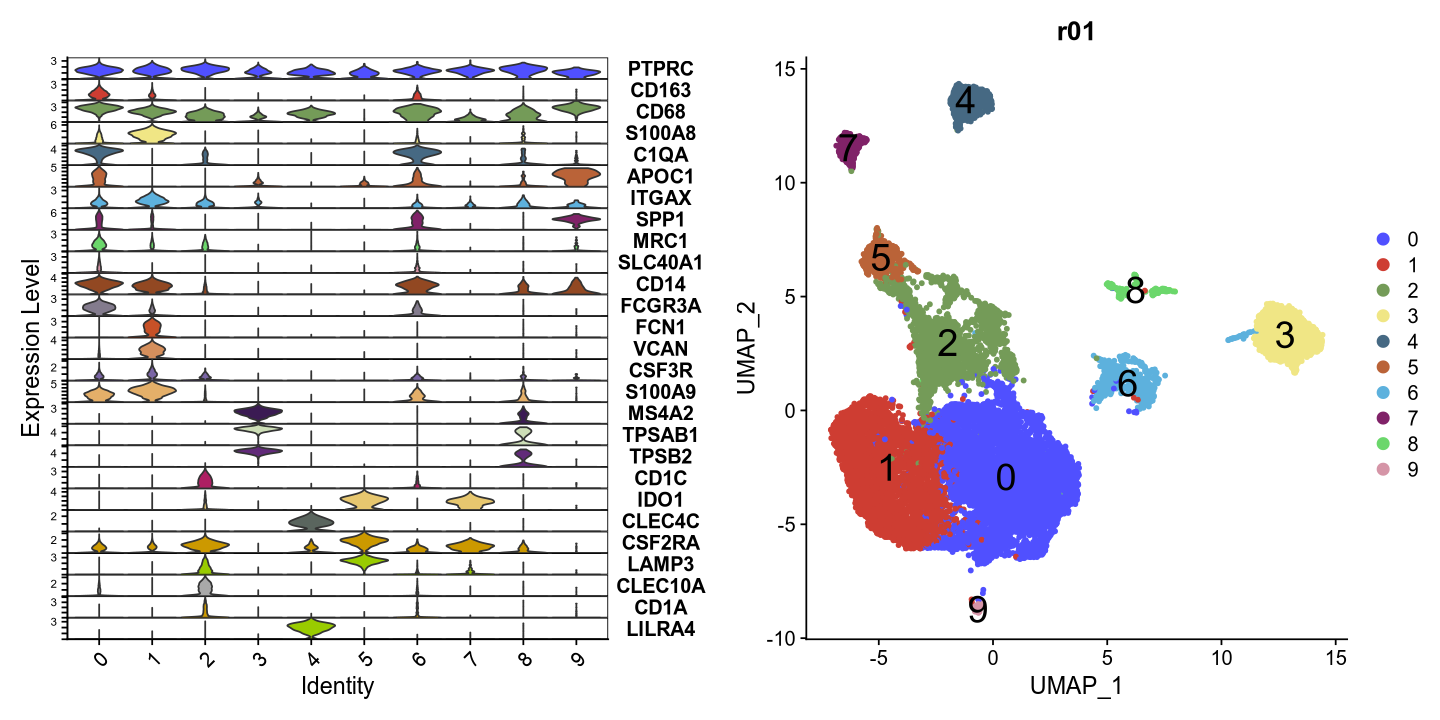

In [248]:
## marker expression
marker_list <- c('PTPRC',  'CD163', 'CD68', 'S100A8','C1QA', 'APOC1', 'ITGAX','SPP1','MRC1', 'SLC40A1', ## Mph
                 'CD14', 'FCGR3A','FCN1', 'VCAN',  ## monocyte
                 'CSF3R', 'S100A8', 'S100A9', ## neutrophil
                 'MS4A2', 'TPSAB1', 'TPSB2', ## mast
                 'CD1C', 'IDO1', 'CLEC4C', 'CSF2RA', 'LAMP3', 'CLEC10A', 'CD1A', 'LILRA4'  ## DC
                 )

options(repr.plot.height = 6, repr.plot.width = 12)
VlnPlot(obj.ESCA.mye, group.by = 'r01', features = marker_list, pt.size = 0, cols = pal_igv("default")(51), 
        slot = 'data',assay = 'RNA', raster=FALSE, stack = TRUE, flip = TRUE)+
theme(legend.position = 'none')|
DimPlot_scCustom(obj.ESCA.mye, pt.size = 1, reduction = 'umap', group.by = "r01", label = TRUE, label.size = 8, colors_use = pal_igv("default")(51))

In [211]:
Idents(obj.ESCA.mye) <- factor(obj.ESCA.mye$r01, levels = 9:0)
cluster_deg <- FindAllMarkers(obj.ESCA.mye, assay = "RNA", slot = "data",
                              logfc.threshold = 0.25, min.pct = 0.1, test.use = "wilcox")
rownames(cluster_deg) <- NULL

Calculating cluster 9

Calculating cluster 8

Calculating cluster 7

Calculating cluster 6

Calculating cluster 5

Calculating cluster 4

Calculating cluster 3

Calculating cluster 2

Calculating cluster 1

Calculating cluster 0



In [279]:
## assign mCT/dCT
obj.ESCA.mye@meta.data <- obj.ESCA.mye@meta.data %>%
                          mutate(dCT = case_when(r01 %in% c('0', '9') ~ 'Mph',
                                                 r01 %in% c('1') ~ 'Mono',
                                                 r01 %in% c('2', '7') ~ 'cDC',
                                                 r01 %in% c('3') ~ 'Mast',
                                                 r01 %in% c('4') ~ 'pDC',
                                                 r01 %in% c('5') ~ 'tDC', ## tolerogenic DC
                                                 r01 %in% c('6') ~ 'Mph_proliferation',
                                                 r01 %in% c('8') ~ 'Plasma',
                                                 TRUE ~ 'Others'
                                                 )) %>%
                          mutate(mCT = case_when(r01 %in% c('0', '9', '6') ~ 'Mph',
                                                 r01 %in% c('1') ~ 'Mono',
                                                 r01 %in% c('2', '4', '5', '7') ~ 'DC',
                                                 r01 %in% c('3') ~ 'Mast',
                                                 r01 %in% c('8') ~ 'B',
                                                 TRUE ~ 'Others'
                                                 ))
obj.ESCA.mye@meta.data <- obj.ESCA.mye@meta.data %>% dplyr::select(-c('r02', 'r03', 'seurat_clusters'))

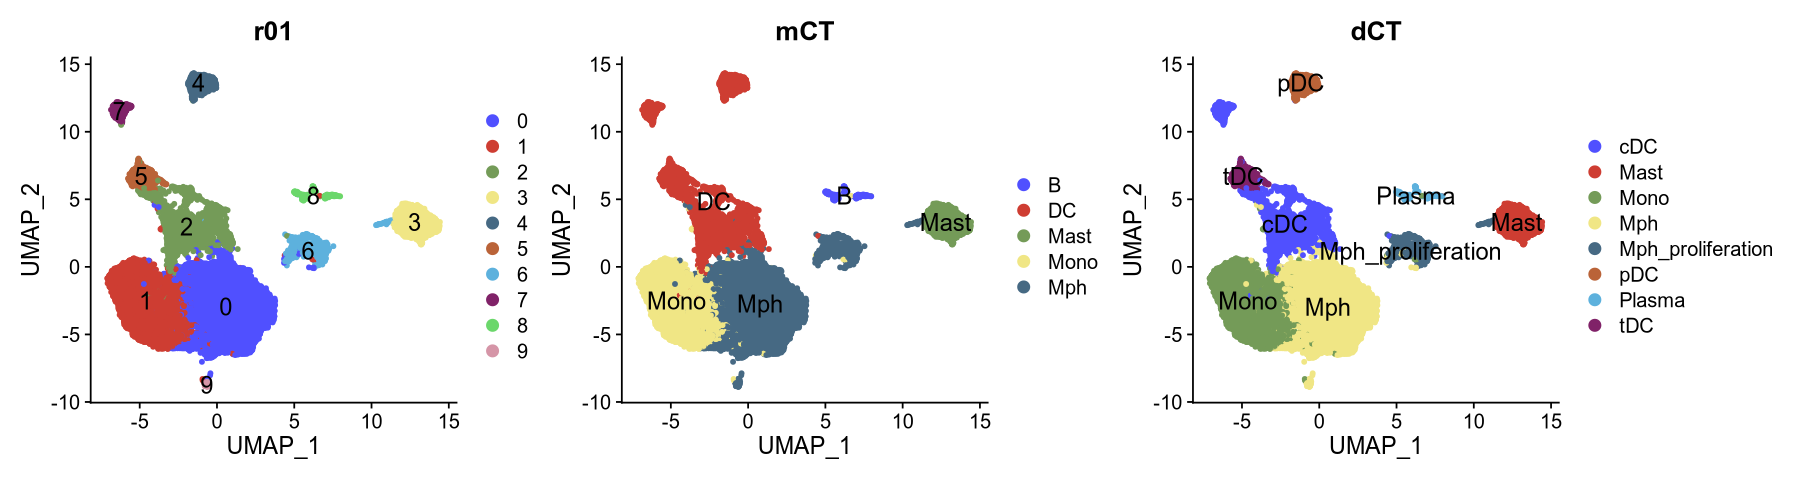

In [280]:
options(repr.plot.height = 4, repr.plot.width = 15)
DimPlot_scCustom(obj.ESCA.mye, pt.size = 1, group.by = "r01", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.mye, pt.size = 1, group.by = "mCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA.mye, pt.size = 1, group.by = "dCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))

## assign mCT/dCT

In [299]:
obj.ESCA.nkt@meta.data <- obj.ESCA.nkt@meta.data %>% dplyr::select(-c('r03', 'r04'))
obj.ESCA.bp@meta.data <- obj.ESCA.bp@meta.data %>% dplyr::select(-c('r01'))
obj.ESCA.mye@meta.data <- obj.ESCA.mye@meta.data %>% dplyr::select(-c('r01'))
table(names(obj.ESCA.nkt@meta.data) == names(obj.ESCA.bp@meta.data))
table(names(obj.ESCA.nkt@meta.data) == names(obj.ESCA.mye@meta.data))


TRUE 
  18 


TRUE 
  18 

In [306]:
obj.ESCA.others <- obj.ESCA %>% subset(dCT %in% c('NK/T', 'B/Plasma', 'Myeloid') == FALSE)
obj.ESCA.others@meta.data <- obj.ESCA.others@meta.data %>% transform(mCT = dCT)
table(names(obj.ESCA.others@meta.data) == names(obj.ESCA.nkt@meta.data))


TRUE 
  18 

In [3]:
obj.ESCA <- merge(obj.ESCA.others, c(obj.ESCA.nkt, obj.ESCA.bp, obj.ESCA.mye))
obj.ESCA

## assign gCT

In [325]:
obj.ESCA@meta.data <- obj.ESCA@meta.data %>%
                          mutate(gCT = case_when(mCT %in% c('Tumor') ~ 'Tumor',
                                                 mCT %in% c('DC', 'Mono', 'Mph', 'Mast', 'CD8T', 'Treg', 'CD4T', 'NK', 'NKT', 'Plasma', 'B') ~ 'Immune',
                                                 mCT %in% c('Endo', 'Fibro', 'FRC', 'Pericyte') ~ 'Stromal',
                                                 TRUE ~ 'Others'
                                                 ))

# run UMAP

In [4]:
obj.ESCA <- obj.ESCA %>%
             NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000, verbose = F) %>%
             FindVariableFeatures(selection.method = "vst", nfeatures = 3000, verbose = F) %>%
             ScaleData(vars.to.regress = c("nCount_RNA"), verbose = F) %>%
             RunPCA(verbose = F) %>% 
             RunHarmony(group.by.vars = "SampleID", plot_convergence = TRUE)
## cluster
nPC <- min(PC_selection_harmony(obj.ESCA)$PCselect)
obj.ESCA <- obj.ESCA %>% 
                RunUMAP(reduction = "harmony", dims = 1:nPC, umap.method = "uwot")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



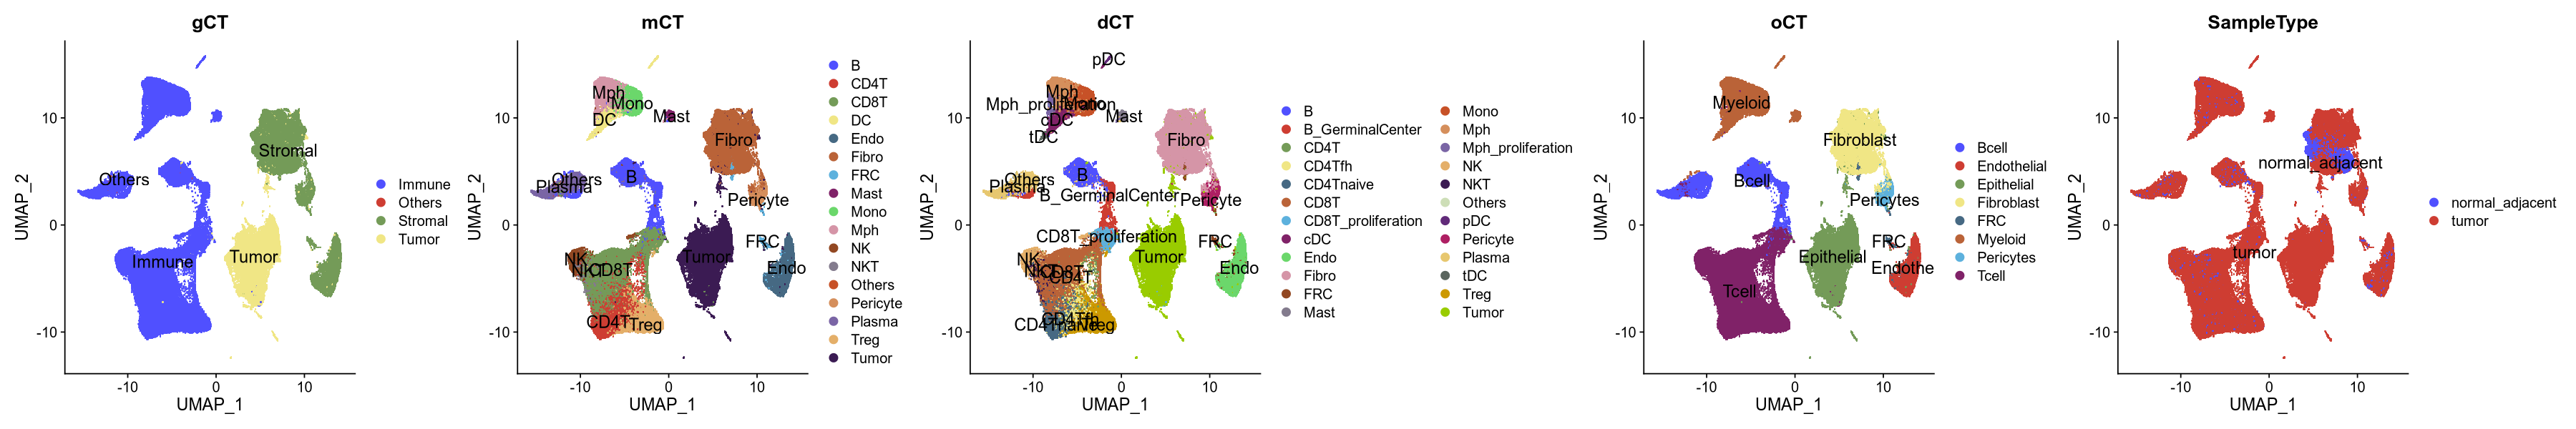

In [10]:
options(repr.plot.height = 5, repr.plot.width = 30)
select <- 'umap'
DimPlot_scCustom(obj.ESCA, pt.size = 1, reduction = select, group.by = "gCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA, pt.size = 1, reduction = select, group.by = "mCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA, pt.size = 1, reduction = select, group.by = "dCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA, pt.size = 1, reduction = select, group.by = "oCT", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))|
DimPlot_scCustom(obj.ESCA, pt.size = 1, reduction = select, group.by = "SampleType", label = TRUE, label.size = 5, colors_use = pal_igv("default")(51))

In [33]:
obj.ESCA@meta.data[,c('SampleID', 'SampleType', 'Sex')] %>% .[!duplicated(.$SampleID),] %$% table(.$SampleType, .$Sex)

                 
                   F  M
  normal_adjacent  0  4
  tumor           16 44

# save

In [16]:
saveRDS(obj.ESCA, 'obj.ESCA.use.rds')